# Deep Reinforcement Learning for Portfolio Optimization


This experiement demonstrates the application of deep reinforcement learning (DRL) techniques for portfolio optimization.

By leveraging state-of-the-art DRL algorithms, we aim to create a robust trading strategy that dynamically adjusts portfolio allocations to maximize returns while minimizing risks.

Policy network architecture: **EI3 (Inception) backbone**

- Compares `A2C`, `PPO`, `SAC`, `DDPG`, `TD3` all with simple MLPs

The workflow includes:

- Data preprocessing
- Feature engineering
- Environment setup
- Training of DRL agents
- Backtesting
- Benchmarking against traditional strategies


## Dependencies


In [1]:
# ! pip install pandas numpy matplotlib \
#                stable-baselines3 \
#                PyPortfolioOpt \
#                pandas_market_calendars quantstats gymnasium \
#                git+https://github.com/AI4Finance-Foundation/FinRL.git -q

In [2]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from scipy.optimize import minimize

import torch

from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import (
    PortfolioOptimizationEnv,
)
from finrl.agents.portfolio_optimization.models import DRLAgent as POAgent
from finrl.agents.portfolio_optimization.architectures import EI3

In [3]:
import warnings

# warnings.filterwarnings("ignore")

%matplotlib inline

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [5]:
experiment_name = "portfolio_optimization_ei3_pg"
results_dir = f"results/models/{experiment_name}"
os.makedirs(results_dir, exist_ok=True)

## Data loading and pre-processing


Define training and trading/test periods


In [6]:
start_date = "2015-01-01"
end_date = (datetime.now() - pd.Timedelta(days=1)).strftime("%Y-%m-%d")  # Yesterday

trade_period = 2  # 2 years for testing
train_period = 10  # 10 years for training

train_end_date = (
    datetime.strptime(end_date, "%Y-%m-%d") - timedelta(days=trade_period * 365)
).strftime("%Y-%m-%d")
train_start_date = (
    datetime.strptime(train_end_date, "%Y-%m-%d") - timedelta(days=train_period * 365)
).strftime("%Y-%m-%d")
test_start_date = (
    datetime.strptime(train_end_date, "%Y-%m-%d") + timedelta(days=1)
).strftime("%Y-%m-%d")

train_dates = (train_start_date, train_end_date)
test_dates = (test_start_date, end_date)

print(f"Training period: {train_dates}")
print(f"Testing period: {test_dates}")

Training period: ('2013-05-02', '2023-04-30')
Testing period: ('2023-05-01', '2025-04-29')


- Fetch historical stock data for a given list of tickers within a specified date range.
- We use the DOW_30_TICKER stocks
- The data includes `date`, `close`, `high`, `low`, `open`, `volume`, and `tic` (ticker symbol).


In [7]:
def download_data(tickers, start_date, end_date):
    print(f"Downloading {start_date} → {end_date}")
    return YahooDownloader(
        start_date=start_date, end_date=end_date, ticker_list=tickers
    ).fetch_data()


tickers = config_tickers.DOW_30_TICKER

raw_df = download_data(tickers, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (76791, 8)


---

### Feature Engineering

We apply feature engineering to the dataset of stock data:

- Add technical indicators (e.g., moving averages, RSI).
- Calculate turbulence indicators, which measure market volatility.

This Enhance the dataset with features that are critical for modeling market dynamics and making informed trading decisions.


In [8]:
def preprocess_data(df):
    fe = FeatureEngineer(use_technical_indicator=True, use_turbulence=True)
    return fe.preprocess_data(df)


df_feat = preprocess_data(raw_df)

# if df_all.empty:
#     print("Preprocessing data...")
#     df_feat = preprocess_data(raw_df)
#     df_feat.to_csv("data/df_all.csv")
# else:
#     print("Using cached data...")
#     df_feat = df_all.copy()
#     df_feat = df_feat[df_feat.index >= start_date]
#     df_feat = df_feat[df_feat.index <= end_date]

Successfully added technical indicators
Successfully added turbulence index


## Covariance & Returns for State


- Calculate the rolling covariance matrices and daily returns for the given dataset of stock prices.
- This prepares the state representation (the state of the portfolio) for the RL models in the RL environments for portfolio optimization.
- The **rolling covariance matrices** (`cov_list`) capture the relationships between asset returns, while the daily returns (`return_list`) provide information about recent price movements.
- These metrics are critical for modeling the dynamics of the financial market and making informed trading decisions.


In [9]:
def compute_covariance_and_returns(df_feat, lookback=252):
    df_sorted = df_feat.sort_values(["date", "tic"], ignore_index=True)
    df_sorted.index = df_sorted.date.factorize()[0]
    cov_list, return_list = [], []

    dates = df_sorted.date.unique()
    for i in range(lookback, len(dates)):
        win = df_sorted.loc[i - lookback : i]
        pm = win.pivot_table(index="date", columns="tic", values="close")
        rm = pm.pct_change().dropna()
        cov_list.append(rm.cov().values)
        return_list.append(rm)
    df_cov = pd.DataFrame(
        {"date": dates[lookback:], "cov_list": cov_list, "return_list": return_list}
    )

    return pd.merge(df_feat, df_cov, on="date", how="left").dropna(subset=["cov_list"])


df_all = compute_covariance_and_returns(df_feat)

## Train/Trade split


In [10]:
def split_data(df_all, train_dates, test_dates):
    train = data_split(df_all, *train_dates)
    test = data_split(df_all, *test_dates)
    return train, test


train_df, test_df = split_data(df_all, train_dates, test_dates)

## Environment setup


- Create instances of the **PortfolioOptimizationEnv** class for both training and testing datasets.
- It also wrap the training environment for use with Stable-Baselines3 (SB3).


In [11]:
def initialize_portfolio_env(df):
    env = PortfolioOptimizationEnv(
        df,
        initial_amount=100_000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"],
        normalize_df=None,
        new_gym_api=True,
    )

    env.df = df.reset_index(drop=True)

    return env


train_env = initialize_portfolio_env(train_df)

## Training


- Set PolicyGradient algorithm and EIIE architecture arguments


In [12]:
model_kwargs = {"lr": 0.01, "policy": EI3, "device": device}
# Set EIIE architecture arguments
policy_kwargs = {
    "k_short": 3,  # short‐term conv kernel
    "k_medium": 21,  # medium‐term conv kernel
    "conv_mid_features": 3,  # intermediate channels
    "conv_final_features": 20,
    "time_window": 50,  # same as PortfolioOptimizationEnv(time_window)
    "device": device,
}
model = POAgent(train_env).get_model("pg", device, model_kwargs, policy_kwargs)

- Train the model


In [13]:
start_time = time.time()

trained_model = POAgent.train_model(model, episodes=64)

end_time = time.time()
training_duration = (end_time - start_time) / 60
print(f"Training completed in {training_duration:.2f} minutes.")

  0%|          | 0/64 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 136513.484375
Final accumulative portfolio value: 1.365134835243225
Maximum DrawDown: -0.7792004434480897
Sharpe ratio: 0.301397567820581


  2%|▏         | 1/64 [00:17<17:56, 17.09s/it]

Initial portfolio value:100000
Final portfolio value: 207633.8125
Final accumulative portfolio value: 2.076338052749634
Maximum DrawDown: -0.24670321971642695
Sharpe ratio: 0.6822827978198026


  3%|▎         | 2/64 [00:34<17:37, 17.05s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
  5%|▍         | 3/64 [00:54<18:52, 18.57s/it]/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
  6%|▋         | 4/64 [01:15<19:38, 19.64s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
  8%|▊         | 5/64 [01:33<18:46, 19.10s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
  9%|▉         | 6/64 [01:52<18:21, 18.99s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 11%|█         | 7/64 [02:09<17:28, 18.39s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 12%|█▎        | 8/64 [02:26<16:43, 17.92s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 14%|█▍        | 9/64 [02:43<16:12, 17.69s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 16%|█▌        | 10/64 [03:01<15:59, 17.76s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan
Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 17%|█▋        | 11/64 [03:18<15:30, 17.56s/it]/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 19%|█▉        | 12/64 [03:36<15:06, 17.44s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 20%|██        | 13/64 [03:53<14:41, 17.28s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 22%|██▏       | 14/64 [04:09<14:18, 17.17s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 23%|██▎       | 15/64 [04:27<13:59, 17.13s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 25%|██▌       | 16/64 [04:44<13:54, 17.39s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 27%|██▋       | 17/64 [05:02<13:33, 17.31s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 28%|██▊       | 18/64 [05:19<13:12, 17.23s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 30%|██▉       | 19/64 [05:36<12:51, 17.14s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 31%|███▏      | 20/64 [05:53<12:33, 17.13s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan
Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 33%|███▎      | 21/64 [06:10<12:14, 17.08s/it]/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 34%|███▍      | 22/64 [06:27<11:55, 17.03s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 36%|███▌      | 23/64 [06:43<11:35, 16.96s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 38%|███▊      | 24/64 [07:00<11:17, 16.94s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 39%|███▉      | 25/64 [07:17<11:01, 16.95s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 41%|████      | 26/64 [07:34<10:43, 16.94s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 42%|████▏     | 27/64 [07:51<10:26, 16.92s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 44%|████▍     | 28/64 [08:08<10:08, 16.89s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 45%|████▌     | 29/64 [08:25<09:51, 16.91s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 47%|████▋     | 30/64 [08:43<09:49, 17.35s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 48%|████▊     | 31/64 [09:01<09:34, 17.39s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 50%|█████     | 32/64 [09:18<09:12, 17.26s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan
Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 52%|█████▏    | 33/64 [09:35<08:54, 17.25s/it]/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 53%|█████▎    | 34/64 [09:51<08:29, 16.98s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 55%|█████▍    | 35/64 [10:08<08:06, 16.79s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 56%|█████▋    | 36/64 [10:24<07:46, 16.67s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 58%|█████▊    | 37/64 [10:40<07:28, 16.59s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 59%|█████▉    | 38/64 [10:57<07:09, 16.50s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 61%|██████    | 39/64 [11:13<06:51, 16.46s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 62%|██████▎   | 40/64 [11:29<06:34, 16.42s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 64%|██████▍   | 41/64 [11:46<06:17, 16.39s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 66%|██████▌   | 42/64 [12:02<05:59, 16.36s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 67%|██████▋   | 43/64 [12:18<05:44, 16.40s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 69%|██████▉   | 44/64 [12:35<05:28, 16.42s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 70%|███████   | 45/64 [12:51<05:12, 16.42s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 72%|███████▏  | 46/64 [13:08<04:55, 16.42s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 73%|███████▎  | 47/64 [13:24<04:39, 16.43s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 75%|███████▌  | 48/64 [13:41<04:22, 16.43s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 77%|███████▋  | 49/64 [13:57<04:06, 16.46s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 78%|███████▊  | 50/64 [14:14<03:49, 16.43s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 80%|███████▉  | 51/64 [14:30<03:33, 16.43s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 81%|████████▏ | 52/64 [14:47<03:18, 16.52s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 83%|████████▎ | 53/64 [15:03<03:00, 16.44s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 84%|████████▍ | 54/64 [15:19<02:44, 16.46s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 86%|████████▌ | 55/64 [15:36<02:28, 16.45s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 88%|████████▊ | 56/64 [15:52<02:11, 16.39s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 89%|████████▉ | 57/64 [16:08<01:54, 16.37s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 91%|█████████ | 58/64 [16:25<01:38, 16.36s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 92%|█████████▏| 59/64 [16:41<01:21, 16.34s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 94%|█████████▍| 60/64 [16:58<01:05, 16.41s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 95%|█████████▌| 61/64 [17:14<00:49, 16.46s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 97%|█████████▋| 62/64 [17:31<00:32, 16.43s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
 98%|█████████▊| 63/64 [17:47<00:16, 16.39s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan


/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor
100%|██████████| 64/64 [18:03<00:00, 16.93s/it]

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan
Training completed in 18.06 minutes.


In [14]:
training_times_df = pd.DataFrame(
    [{"model": "EI3_PG", "training_duration (min)": training_duration}]
)
training_times_df.to_csv(f"{results_dir}/training_times.csv", index=False)

# Display training summary
print("Training summary:")
display(training_times_df)

Training summary:


,model,training_duration (min)
0,EI3_PG,18.060551


In [15]:
model_path = f"{results_dir}/ei3_pg.pth"

In [16]:
torch.save(trained_model.train_policy.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to results/models/portfolio_optimization_ei3_pg/ei3_pg.pth


## Backtesting


In [17]:
policy = EI3(time_window=50, device=device)
policy.load_state_dict(torch.load(model_path, map_location=device))
# policy = policy.to(device)
# policy.eval()
print("Model loaded and ready for evaluation.")
print("Evaluating model on test data...")

test_env = initialize_portfolio_env(test_df.reset_index(drop=True))

Model loaded and ready for evaluation.
Evaluating model on test data...


In [18]:
def portfolio_test(env, policy, initial_last_action=None):
    obs, _ = env.reset()
    obs = np.asarray(obs, dtype=np.float32)

    # Initial last_action
    if initial_last_action is None:
        action_dim = env.action_space.shape[0]
        last_action = np.ones(action_dim, dtype=np.float32) / action_dim
    else:
        last_action = np.asarray(initial_last_action).flatten().astype(np.float32)

    done = False
    transitions = []

    while not done:
        # Create batches
        obs_batch = obs[None, ...]
        la_batch = last_action[None, ...]

        # Policy forward
        action = policy(obs_batch, la_batch)
        action = np.asarray(action).flatten().astype(np.float32)

        # Step
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = bool(terminated or truncated)

        next_obs = np.asarray(next_obs, dtype=np.float32)

        # Record
        transitions.append(
            {
                "obs": obs,
                "last_action": last_action,
                "action": action,
                "reward": float(reward),
                "info": info,
            }
        )

        # Advance
        obs = next_obs
        last_action = action

    return transitions


transitions = portfolio_test(test_env, policy)

print(f"Collected {len(transitions)} steps.")
print("Rewards:", [t["reward"] for t in transitions])

Initial portfolio value:100000
Final portfolio value: 100000.0
Final accumulative portfolio value: 1.0
Maximum DrawDown: 0.0
Sharpe ratio: nan
Collected 451 steps.
Rewards: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

/Users/mzitoh/anaconda3/envs/portfolio_opt/lib/python3.12/site-packages/quantstats/stats.py:294: RuntimeWarning: invalid value encountered in scalar divide
  res = returns.mean() / divisor


In [19]:
# Inspect rewards or info:
infosrewards = [t["reward"] for t in transitions]
infos = [t["info"] for t in transitions]

## Benchmarks


In [20]:
# Get portfolio values
eiie_values = test_env._asset_memory["final"]
bh_values = []

In [21]:
# Calculate Buy & Hold
test_env.reset()
action = [1 / len(tickers)] * len(tickers)
done = False
while not done:  # Use test_env._done to check episode completion
    test_obs, rewards, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated
    bh_values.append(test_env._portfolio_value)

Initial portfolio value:100000
Final portfolio value: 118570.15625
Final accumulative portfolio value: 1.185701608657837
Maximum DrawDown: -0.14329387406545524
Sharpe ratio: 0.7813411376938388


In [22]:
risk_free_rate = 0.043  # 4.3% annualized

In [23]:
# Calculate metrics
def calculate_metrics(values, risk_free_rate):
    returns = pd.Series(values).pct_change().dropna()
    cumulative_return = (values[-1] / values[0]) - 1
    annualized_return = (1 + cumulative_return) ** (252 / len(returns)) - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - risk_free_rate) / volatility
    max_drawdown = (values / np.maximum.accumulate(values) - 1).min()

    return {
        "Cumulative Return": cumulative_return,
        "Annualized Return": annualized_return,
        "Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
    }


eiie_metrics = calculate_metrics(eiie_values, risk_free_rate)
bh_metrics = calculate_metrics(bh_values, risk_free_rate)

/var/folders/kd/9h3yrkps2vj0t9zs17vt349c0000gn/T/ipykernel_3018/3055681785.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  sharpe_ratio = (annualized_return - risk_free_rate) / volatility


In [24]:
# Step 1: Define metrics
metrics = [
    "Cumulative Return",
    "Annualized Return",
    "Volatility",
    "Sharpe Ratio",
    "Max Drawdown",
]

# Step 2: Create DataFrame
metrics_df = pd.DataFrame(
    {
        "Metric": metrics,
        "EI3": [eiie_metrics[m] for m in metrics],
        "Buy & Hold": [bh_metrics[m] for m in metrics],
    }
)

## Performance Summary


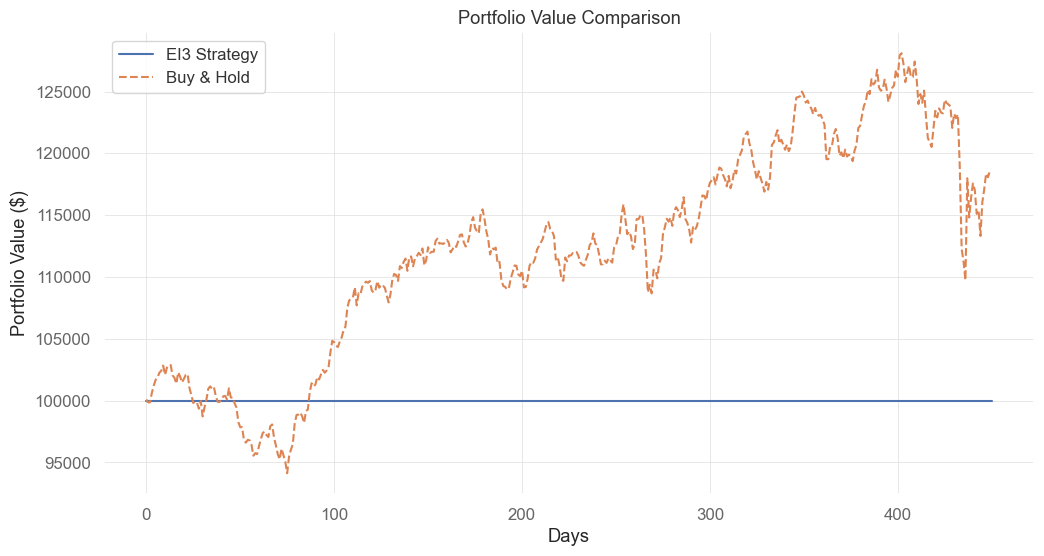

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(eiie_values, label="EI3 Strategy")
plt.plot(bh_values, label="Buy & Hold", linestyle="--")
plt.title("Portfolio Value Comparison")
plt.xlabel("Days")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.show()
plt.close()

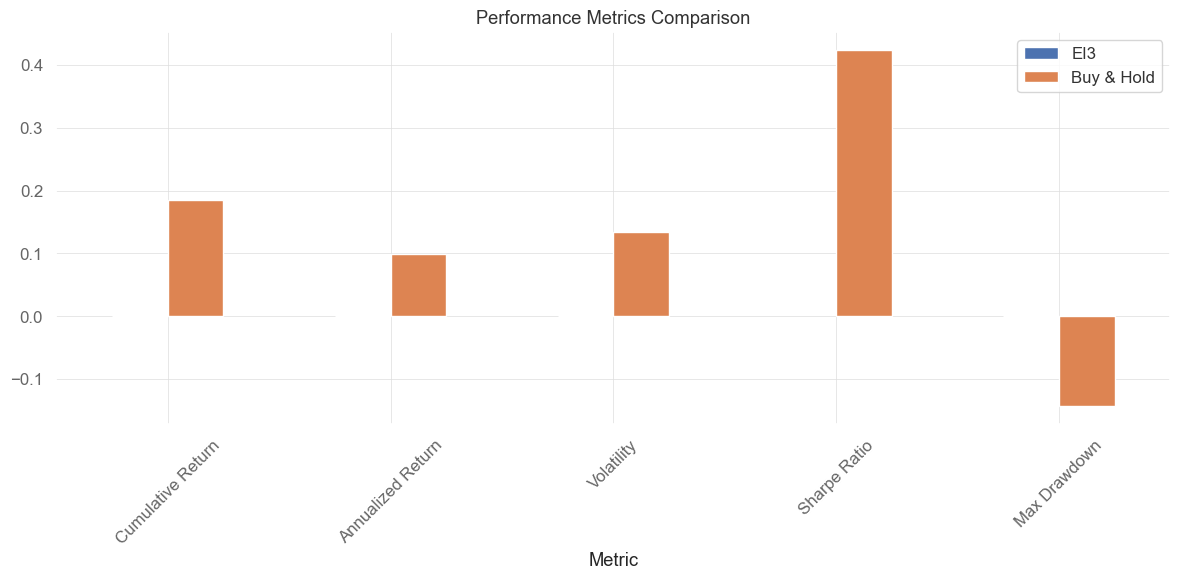

In [26]:
plt.figure(figsize=(12, 6))
metrics_df.set_index("Metric").plot(kind="bar", ax=plt.gca())
plt.title("Performance Metrics Comparison")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.close()

In [27]:
# Display metrics
print("\nPerformance Metrics:")
display(
    metrics_df.style.format(
        {
            "EIIE": "{:.2%}",
            "Buy & Hold": "{:.2%}",
            "Sharpe Ratio": "{:.2f}",
            "Volatility": "{:.2%}",
        }
    )
)


Performance Metrics:


,Metric,EI3,Buy & Hold
0,Cumulative Return,0.000000,18.46%
1,Annualized Return,0.000000,9.95%
2,Volatility,0.000000,13.33%
3,Sharpe Ratio,-inf,42.42%
4,Max Drawdown,0.000000,-14.33%


In [28]:
# Additional Sharpe ratio optimization
log_returns = raw_df.pivot_table(index="date", columns="tic", values="close")
log_returns = np.log(log_returns.pct_change() + 1).dropna()
cov_matrix = log_returns.cov() * 252


def negative_sharpe(weights):
    port_return = np.dot(weights, log_returns.mean()) * 252
    port_vol = np.sqrt(weights.T @ cov_matrix @ weights)
    return -(port_return - risk_free_rate) / port_vol


constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1}
bounds = [(0, 1) for _ in tickers]
initial_weights = np.array([1 / len(tickers)] * len(tickers))

result = minimize(
    negative_sharpe,
    initial_weights,
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
)

print("\nOptimal Weights from Sharpe Ratio Optimization:")
for ticker, weight in zip(tickers, result.x):
    print(f"{ticker}: {weight:.2%}")


Optimal Weights from Sharpe Ratio Optimization:
AXP: 34.19%
AMGN: 0.00%
AAPL: 0.00%
BA: 0.00%
CAT: 1.72%
CSCO: 0.00%
CVX: 0.00%
GS: 0.00%
HD: 0.00%
HON: 0.00%
IBM: 7.76%
INTC: 0.00%
JNJ: 0.00%
KO: 0.00%
JPM: 0.00%
MCD: 0.00%
MMM: 0.00%
MRK: 0.00%
MSFT: 0.00%
NKE: 0.00%
PG: 0.00%
TRV: 2.64%
UNH: 0.00%
CRM: 0.00%
VZ: 0.00%
V: 0.00%
WBA: 0.00%
WMT: 0.00%
DIS: 0.00%
DOW: 53.68%
